<div style="text-align:center">
    <h1>
        REINFORCE
    </h1>
</div>

<br><br>

<div style="text-align:center">
In this notebook we are going to implement the Monte Carlo version of Policy Gradient methods. The REINFORCE algorithm uses the full return to update the policy:
</div>

\begin{equation}
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+1} + \cdots + \gamma^{T-t-1} R_{T}
\end{equation}


<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 10 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import os
import torch
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW

from utils import test_policy_network, seed_everything, plot_stats, plot_action_probs
from parallel_env import ParallelEnv, ParallelWrapper

## Create and preprocess the environment

### Create the environment

In [2]:
env = gym.make('CartPole-v0', render_mode="rgb_array")

/home/kashmira/anaconda3/envs/beginner_rl/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [3]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"CartPole env: State dimensions: {state_dims}, Number of actions: {num_actions}")
print(f"Sample state: {env.reset()}")

CartPole env: State dimensions: 4, Number of actions: 2
Sample state: (array([-0.02447969, -0.03589052, -0.03583437, -0.01536373], dtype=float32), {})


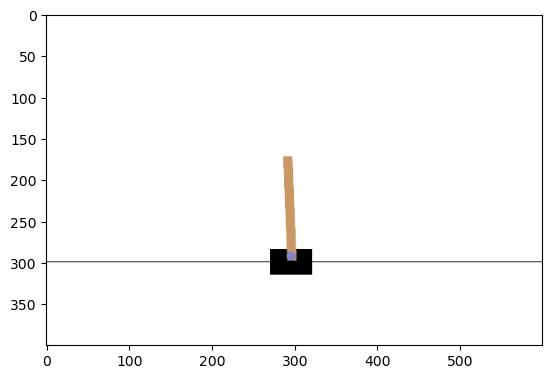

In [4]:
plt.imshow(env.render())

### Parallelize the environment

In [5]:
# num_envs = os.cpu_count() # This function will give us the number of CPU cores to work with several environments
# num_envs = 16
num_envs = 8 # to reduced CPU load

In [6]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env, seed=seed)
    return env

In [7]:
env_fns = [lambda: create_env('CartPole-v0', rank) for rank in range(num_envs)]
print(env_fns[0])

# env_fns = [env_1, ...,env_n]
parallel_env = ParallelEnv(env_fns)
print("\n\n")
print(parallel_env)

<function <listcomp>.<lambda> at 0x7f958996d700>





In [8]:
parallel_env.reset()

array([[ 0.03669938, -0.03708734,  0.02945132, -0.04255056],
       [ 0.03621821, -0.00323977,  0.00696433,  0.0234341 ],
       [ 0.03945774, -0.03318487,  0.0026862 , -0.03162032],
       [-0.03057126,  0.00342982,  0.01363465,  0.03521381],
       [ 0.0315598 ,  0.04178015, -0.01199646,  0.01103602],
       [ 0.02988734,  0.0342712 ,  0.01337716, -0.02360259],
       [-0.02553387, -0.01727324, -0.0154224 ,  0.01064108],
       [ 0.02927287,  0.03887338,  0.00439866,  0.02112222]],
      dtype=float32)

### Prepare the environment to work with PyTorch

In [9]:
class PreprocessEnv(ParallelWrapper):

    def __init__(self, parallel_env):
        ParallelWrapper.__init__(self, parallel_env)

    def reset(self):
        state = self.venv.reset() # self.venv is the parallel_env stored in class ParallelWrapper
        
        return torch.from_numpy(state).float()

    def step_async(self, actions): # actions are originally column vector
        actions = actions.squeeze().numpy()  # remove the extra dimension->make a row vector, then extract a numpy array from the tensor
        self.venv.step_async(actions)

    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1) # unsqueeze converts row vector to col vector

        return next_state, reward, done, info

In [10]:
parallel_env = PreprocessEnv(parallel_env)

In [11]:
state = parallel_env.reset()
_, reward, done, _ = parallel_env.step(torch.zeros((num_envs, 1), dtype=torch.int32))

print(f'State: {state}, Reward: {reward}, Done: {done}')

State: tensor([[-0.0046,  0.0249, -0.0187, -0.0370],
        [-0.0489,  0.0427, -0.0112, -0.0075],
        [-0.0396,  0.0480,  0.0162,  0.0449],
        [ 0.0100,  0.0482, -0.0213,  0.0092],
        [ 0.0160, -0.0286, -0.0304,  0.0494],
        [ 0.0271, -0.0325, -0.0111, -0.0313],
        [-0.0313,  0.0046, -0.0252, -0.0291],
        [-0.0132, -0.0465,  0.0347,  0.0391]]), Reward: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), Done: tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])


### Create the policy $\pi(s)$

In [12]:
policy = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions),
    nn.Softmax(dim=-1))

### Plot action probabilities

In [13]:
neutral_state = torch.zeros(4)
left_danger = torch.tensor([-2.3, 0., 0., 0.])
right_danger = torch.tensor([2.3, 0., 0., 0.])

#### Plot a neutral environment

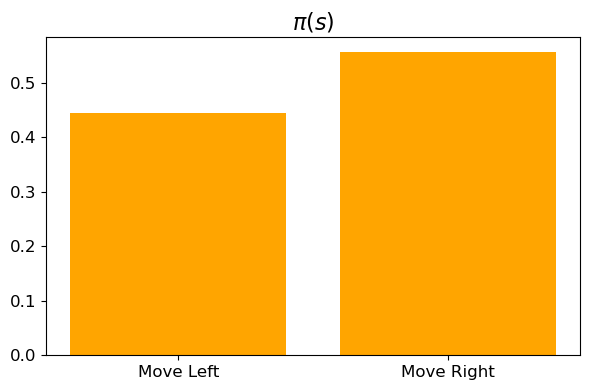

In [14]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

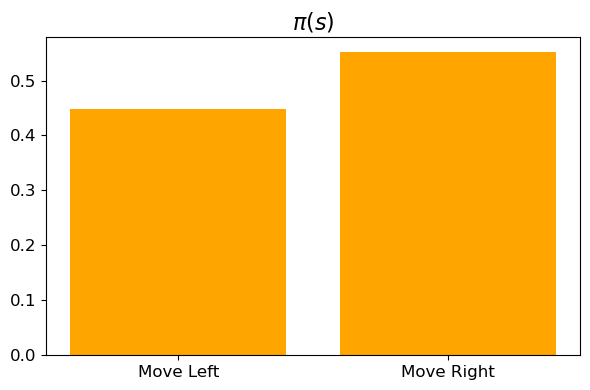

In [15]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

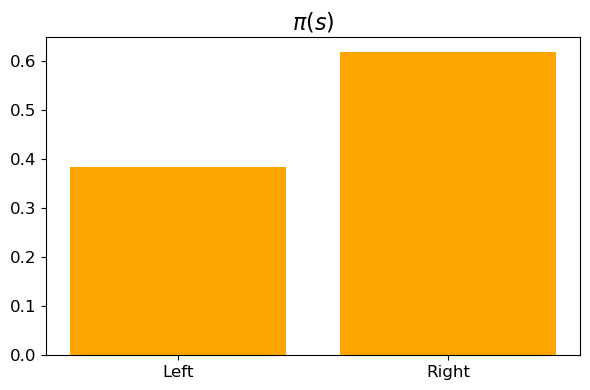

In [16]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

## Implement the algorithm

</br></br>


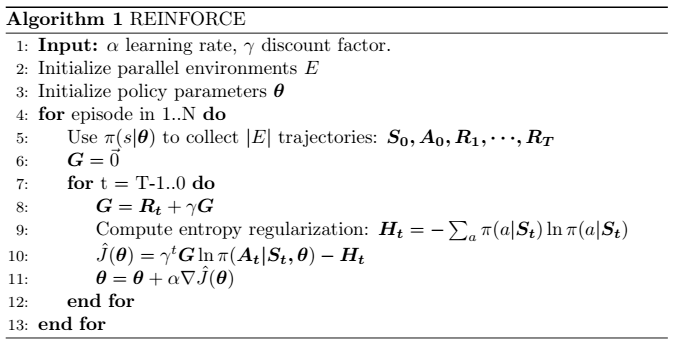

In [17]:
def reinforce(policy, episodes, alpha=0.0001, gamma=0.99):
    optimizer = AdamW(policy.parameters(), lr=alpha)
    stats = {'Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes+1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool) # final done flag
        transitions = []
        ep_return = torch.zeros((num_envs, 1))
        
        while not done_b.all(): # till all envs aren't done
            action = policy(state).multinomial(1).detach() # samples one action from the list of action probablilities
            next_state, reward, done, _ = parallel_env.step(action)
            # the effect of this multiplication will be to convert into zeros all the rewards corresponding to
            # envs, whose episode has already finished.
            transitions.append([state, action, ~done_b * reward])
            ep_return += reward
            state = next_state
            done_b = done_b | done # performs OR operation on two vectors, to update the status of final done flag
            
        G = torch.zeros((num_envs, 1))
            
        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transitions))):
            G = reward_t + gamma * G
            probs_t = policy(state_t) # get action probs from the NN
            log_probs_t = torch.log(probs_t + 1e-6) # to avoid log(0)

            # We choose from that vector of probabilities (log_probs_t) only the prob
            # associated with the action taken at time 't', which is the one that will take 
            # part in the update rule, given by action_log_probs_t
            # gather(1, action_t) takes first dimension and index of the action that we are interested in.
            action_log_probs_t = log_probs_t.gather(1, action_t) 

            entropy_t = -torch.sum(probs_t * log_probs_t, dim=-1, keepdim=True)
            gamma_t = gamma ** t

            # we write the policy's performance in negative because the AdamW object 
            # can only perform gradient descent and in line 11 we are performing gradient ascent
            # so now the AdamW minimizes the negative of policy performance ==> maximizes the performance
            policy_gradient_loss_t = - gamma_t * G * action_log_probs_t
            total_loss_t = (policy_gradient_loss_t - 0.01 * entropy_t).mean()

            # line 11
            policy.zero_grad()
            total_loss_t.backward()
            optimizer.step()
        
        stats['Loss'].append(total_loss_t.item())
        stats['Returns'].append(ep_return.mean().item())

    return stats
            

In [18]:
parallel_env.reset()

stats = reinforce(policy, 200)

100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  6.02it/s]


## Show results

### Show execution stats

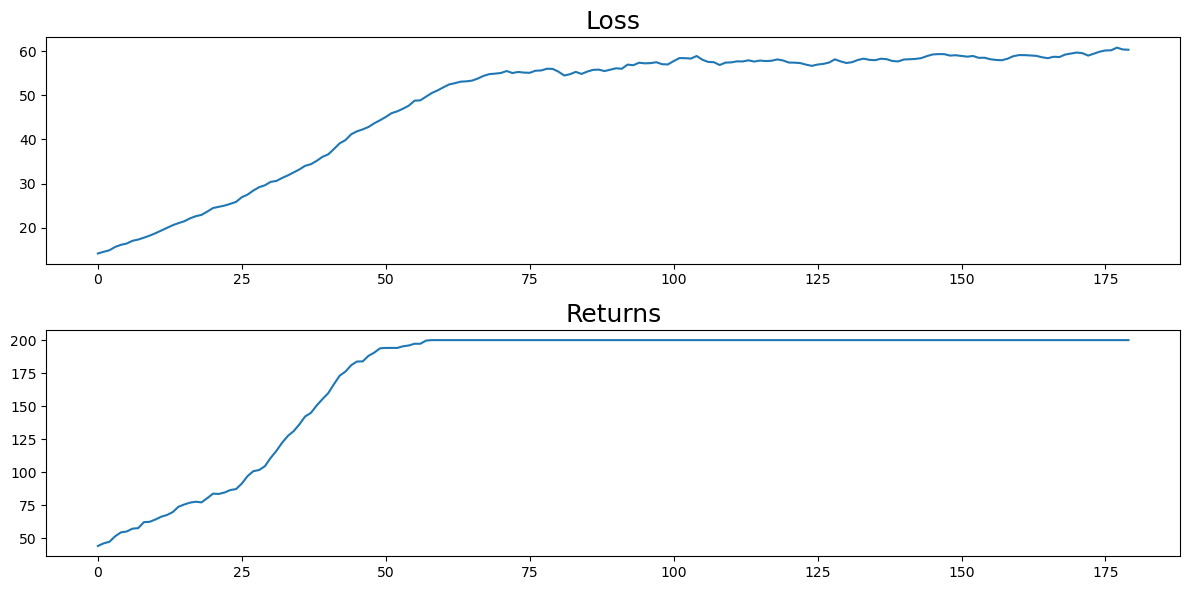

In [19]:
plot_stats(stats)

### Plot action probabilities

#### Plot a neutral environment

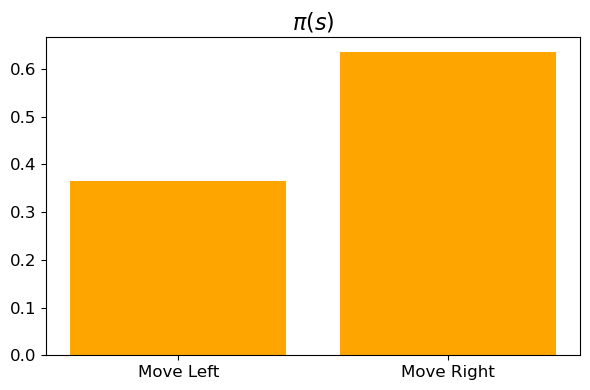

In [20]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

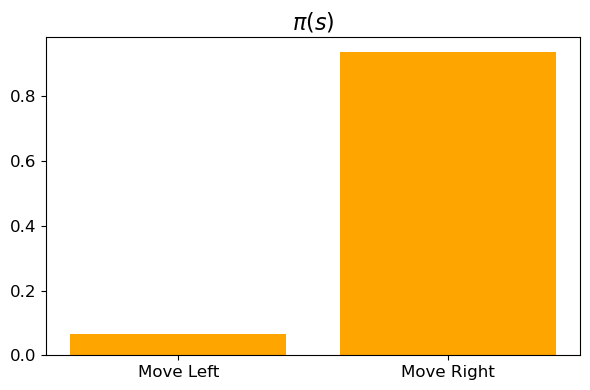

In [21]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

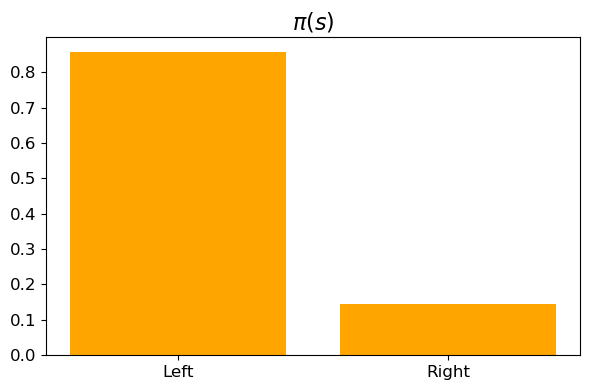

In [22]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

### Test the resulting agent

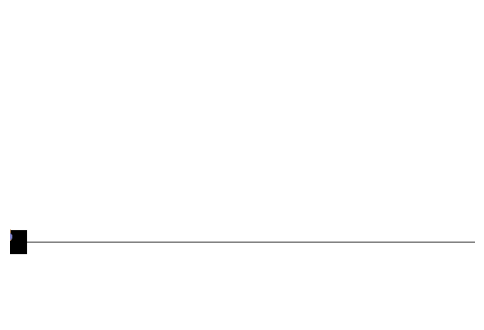

In [24]:
test_policy_network(env, policy, episodes=3)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)